# SCL - Desafío

Para más iformación dirigirse al siguiente link.

<a href="https://gist.github.com/marianocalvoa/a1de91304274e429e3e4c052aa5fe911#file-scl_desafio-ipynb" target="_blank" rel="noopener noreferrer">Desafío para pronóstico de atraso en arribos/partidas de vuelos en el aeropuerto de Santiago De Chile</a>

Publicado Agosto 16 2022.

En este cuaderno analizo un problema de pronóstico de atrasos de arribos o partidas de vuelo "flight departures/arrivals delays" con gran detalle. El encuadre se ajusta al desafío de predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL). Para ello se dispone de un dataset de datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL. Para cada vuelo (arribo/partida) se cuenta con la siguiente información:

Fecha-I: Fecha y hora programada del vuelo.

Vlo-I: Número de vuelo programado.

Ori-I: Código de ciudad de origen programado.

Des-I: Código de ciudad de destino programado.

Emp-I: Código aerolínea de vuelo programado.

Fecha-O: Fecha y hora de operación del vuelo.

Vlo-O: Número de vuelo de operación del vuelo.

Ori-O: Código de ciudad de origen de operación.

Des-O: Código de ciudad de destino de operación.

Emp-O: Código aerolínea de vuelo operado.

DIA: Día del mes de operación del vuelo.

MES: Número de mes de operación del vuelo.

AÑO: Año de operación del vuelo.

DIANOM: Día de la semana de operación del vuelo.

TIPOVUELO: Tipo de vuelo, I =Internacional, N =Nacional.

OPERA: Nombre de aerolínea que opera.

SIGLAORI: Nombre ciudad origen.

SIGLADES: Nombre ciudad destino.

## Table of Contents

1. [Getting Setup](#setup1)<br>
 
2. [Data Exploration](#explore)<br>

3. [Data Transformation and Feature Engineering](#trans)<br>
 
4. [Dealing with rates and correlations](#small)<br>
    4.1 [¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?](#window)<br>
    4.2 [¿Qué variables esperarías que más influyeran en predecir atrasos?](#groups)<br>
5. [Build the Model on the unbalanced Data Set (Random Forest)](#build)<br>
6. [Evaluate model on the unbalanced training and testing data set (Random Forest)](#score)<br>
7. [Build the Model on the balanced Data Set (XGBoost)](#score)<br>
    7.1 [Evaluate the model using an AUC and accuacy metrics](#7.1)<br>
    7.2 [Evaluating with a Confusion Matrix](#7.2)<br>
    7.3 [Using shap_values to reconfigure](#7.3)<br>
8. [Conclusiones: Cómo se podría mejorar la performance de los estimadores](#conc)<br>

### 1.0 Getting Set-Up <a id="setup1"></a>

In [1]:
# Si no desea clonar el repositorio github puede descomentar aquí debajo lo que sigue y utilizar la clave_token de mi proyecto personal definido para el desafio_SCL en el ambiente IBM Cloud Paq For Data (ICP4D):

# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
#from project_lib import Project
#project = Project(project_id='8568290c-dd4e-4248-8e07-a29c6a22794a', project_access_token='p-4f9aa7521c92c00bded127a17a3044db94003d99')
#pc = project.project_context

  Instalar todas la librerías Python relevantes para esta sección

In [2]:
!pip install -U pandas-profiling #Usaré para el descriptive data analytic

     |████████████████████████████████| 262 kB 27.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 709 kB 59.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 76.0 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 66.8 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 31.8 MB/s ta 0:00:01
     |████████████████████████████████| 812 kB 70.8 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=6a4442b9121ec4d7e51ea2f4d3d17bd0e2eab06defc1aaa20a0901323ab1d85e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=716c7745e98855b999149a575b7ef08a3cfaadcbdd9899c65b62d4052478ea08
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/51/f9/a5/740af2fdb0ad1edf79aabdc41531

 Se importan las librerías Python mínimas necesarias de la notebook

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import datetime
from datetime import datetime

 Se cargan los datos del archivo plano para su procesamiento

In [4]:
#Se dispone de 2 opciones para la carga: Desde ambiente de proyecto ICP4D o desde Google Colab una vez clonado desde repositorio Github. Descomente el que se desée:

#df = project.get_file("dataset_SCL.csv")
#df = pd.read_csv(df, sep=',')
#df.info()

#url = 'https://raw.githubusercontent.com/marianocalvoa/SCL_desafio/main/dataset_SCL.csv'
#df = pd.read_csv(url)
#df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.isnull().sum(axis = 0)

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

 OBS: Si bien ya se indicaba en el resumen anterior el único valor missing en el campo 'Vlo-O', aquí arriba se cuentan rápidamente todos los posibles valores missings de cada campo.
 Sin embargo un completo análisis exploratorio de datos es el siguiente.

### 2.0 Data Exporation <a id="explore"></a>

 A continuación se procesa un data exploration analytics (markdown):
¿Cómo se distribuyen los datos?

In [6]:
df['Vlo-O_coerce'] = df['Vlo-O'].apply(lambda x: 1 if pd.to_numeric(x,errors='coerce') > 0 else 0)
df['Vlo-I_coerce'] = df['Vlo-I'].apply(lambda x: 1 if pd.to_numeric(x,errors='coerce') > 0 else 0)
df['coerce'] = df['Vlo-O_coerce'] + df['Vlo-I_coerce']
df[(df.coerce < 2)]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,Vlo-O_coerce,Vlo-I_coerce,coerce
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,...,1,2017,Jueves,I,Latin American Wings,Santiago,Lima,0,1,1
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71R,SCEL,SCIE,SKU,...,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion,0,1,1
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71R,SCEL,SCIE,SKU,...,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion,0,1,1
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201R,SCEL,SCIE,LXP,...,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion,0,1,1
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71R,SCEL,SCIE,SKU,...,4,2017,Martes,N,Sky Airline,Santiago,Concepcion,0,1,1
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43R,SCEL,SCIE,JMR,...,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion,0,1,1
22232,2017-05-13 21:50:00,989P,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,...,5,2017,Sabado,I,American Airlines,Santiago,Montevideo,1,0,1
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401A,SCEL,LFPG,AFR,...,5,2017,Viernes,I,Air France,Santiago,Paris,0,1,1
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401B,SCEL,LFPG,AFR,...,5,2017,Domingo,I,Air France,Santiago,Paris,0,1,1
24304,2017-05-11 10:00:00,802,SCEL,SPJC,SKU,2017-05-11 10:36:00,802R,SCEL,SPJC,SKU,...,5,2017,Jueves,I,Sky Airline,Santiago,Lima,0,1,1


 La tabla de arriba muestra todos los casos de falta de uniformidad de formato en 'Vlo-O' y en 'Vlo_I' como a continuación se indicará con "rechazo" en el report de profiling:

In [7]:
df = df.drop(columns=['Vlo-I_coerce', 'Vlo-O_coerce','coerce'])

In [8]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

 OBS: Se identifican 2 campos 'Vlo-O' y 'Vlo-O' con formatos no estandarizados (rechazos) seguramente por aparición de simbolos, letras, números, (o tokens en general) que perturban la uniformidad del formato que los hace indeterminados.
 Asimismo se identifican campos constantes en 'Ori-I', Ori-O' y 'SIGLAORI' los cuales al no poseer variabilidad no les aplican relaciones de pronósticos variables y por lo tanto no participarán.
 
 Como es de esperar se muestra fuerte concentración (moda) en los vuelos (arribos/partidas) de 'Emp-I' = LAN y menor en 'Emp-O' aunque moda también. Similarmente se concentran los vuelos (arribos/partidas) en el Grupo LATAM ('OPERA') Se observa decrecimiento de vuelos (arribos/partidas) hacia fin de mes que decae a casi la mitad del promedio diario mensual (histograma de 'DIA'). Todos los vuelos (arribos/partidas) son del año 2017 y sólo existen 2 casos ocurridos en el 'AÑO' = 2018.

### 3.0 Data transformations and Feature Engineering <a id="trans"></a>

 Se generan las columnas adicionales y luego se exportan en un archivo "synthetic_features.csv" :
  
temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no. 

dif_min: diferencia en minutos entre Fecha-O y Fecha-I : 1 si dif_min > 15, 0 si no.

atraso_15: 1 si dif_min > 15, 0 si no.

periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .

In [9]:
df['Fecha-I_'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O_'] = pd.to_datetime(df['Fecha-O'])

In [10]:
#dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
df['dif_min'] = df['Fecha-O_'] - df['Fecha-I_']
df['dif_min'] = df['dif_min'].apply(lambda x: x.total_seconds()/60)

In [11]:
#atraso_15 : 1 si dif_min > 15, 0 si no.
df['atraso_15'] = df['dif_min'].apply(lambda x: 1 if x > 15 else 0)

In [12]:
#temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no. 
df['temporada_alta'] = df['Fecha-I_'].apply(lambda x: 1 if 
                                            (((x.month == 12 and x.day >= 15) or (x.month <= 2 or (x.month == 3 and x.day <= 3))) or 
                                            (x.month == 7 and x.day >= 15) or 
                                            (x.month == 9 and x.day >= 11))
                                            else 0)

In [13]:
#periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I .
df['periodo_dia'] = df['Fecha-I_'].apply(lambda x: 'mañana' if (x.hour >= 5 and x.hour < 12) else
                                         (('tarde' if (x.hour >= 12 and x.hour < 19) else 'noche')))

In [14]:
synthetic_features = df[['dif_min','temporada_alta','periodo_dia','atraso_15']]

 A continuación se exporta el csv de sólo los 5 campos ('dif_min','temporada_alta','periodo_dia','atraso_15') indicados en el desafío:

In [15]:
# Según los casos elegidos descomente alguna de las 3 opciones de exportación del dataframe:

# Opción Github:
#synthetic_features.to_csv("https://github.com/marianocalvoa/SCL_desafio/synthetic_features.csv")

#Opción Google Colab: Reemplazar la carpeta "sample_data" por la que corresponda al ambiente de desarrollo python elegido de la clonación descomente lo siguiente:
#synthetic_features.to_csv('sample_data/synthetic_features.csv')

# Opcion Local (Anaconda, ICP4D, etc) Una tercera opción una vez incorporado el token_key del proyecto arriba indicados permite exportar a los activo 
# del proyecto en el ambiente de desarrollo que admita las librerías python elegido, según lo siguiente:
#project.save_data(data=synthetic_features.to_csv(),file_name='synthetic_features.csv',overwrite=True)

{'file_name': 'synthetic_features.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'centrodecompetenciascognitivotele-donotdelete-pr-upoy14wnekd2o5',
 'asset_id': '5e5b0a4e-103c-418b-9254-9615204c371e'}

In [16]:
#synthetic_features.to_csv("https://github.com/marianocalvoa/SCL_desafio.git/synthetic_features.csv")

### 4.0 Dealing with rates and correlations <a id="trans"></a>

#### 4.1 ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? <a id="window"></a>

In [17]:
#3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? 
    #¿Qué variables esperarías que más influyeran en predecir atrasos?

deso = df.groupby("Des-O")["atraso_15"].agg(['mean', 'sum','count']).round(2)
deso = deso.sort_values(["mean","count"], ascending = (False, True))

empo = df.groupby("Emp-O")["atraso_15"].agg(['mean', 'sum','count']).round(2)
empo = empo.sort_values(["mean","count"], ascending = (False, True))

mes = df.groupby("MES")["atraso_15"].agg(['mean', 'sum','count']).round(2)
mes = mes.sort_values(["mean","count"], ascending = (False, True))

dianom = df.groupby("DIANOM")["atraso_15"].agg(['mean', 'sum','count']).round(2)
dianom = dianom.sort_values(["mean","count"], ascending = (False, True))

t_a = df.groupby("temporada_alta")["atraso_15"].agg(['mean', 'sum','count']).round(2)
t_a = t_a.sort_values(["mean","count"], ascending = (False, True))

tipovuelo = df.groupby("TIPOVUELO")["atraso_15"].agg(['mean', 'sum','count']).round(2)
tipovuelo = tipovuelo.sort_values(["mean","count"], ascending = (False, True))

In [18]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [19]:
display_side_by_side(deso,empo,mes,dianom,t_a,tipovuelo, titles=['DESTINO','AEROLÍNEA','MES','DÍA','TEMPORADA','TIPO DE VUELO'])

,mean,sum,count
Des-O,,,
EGYP,1.00,1,1
SLCB,1.00,1,1
SEQM,1.00,2,2
SAWH,0.67,4,6
YSSY,0.58,113,194
YMML,0.54,21,39
SAZS,0.50,1,2
SAAR,0.40,54,136
NZAA,0.37,135,361


OBS: Las 6 tablas de arriba representan las agrupaciones de casos respectivamente por 'Des-O', 'Emp-O', 'MES', 'DIANOM', 'temporada_alta' y 'TIPOVUELO'. En cada una se toma el promedio (o media) del campo 'atraso_15' el cual resulta en la tasa de atraso del grupo.
La visualización de cada tabla es de mayor a menor tasa de atraso. Por lo tanto en lo más alto de la tabla se muestran las clases del campo agrupador que más se atrasan.
Así todos los casos en cada agrupación quedan ordenados en sus atrasos de vuelo (columna 'mean'), su relativa importancia o representación de atraso de un vuelo debe ser entendido en el conteo de los casos con atraso del grupo (columna 'sum') respecto del conteo de casos total del grupo (columna 'count') para relativizar el peso (desbalanceado) que pueda dar en un modelo de entrenamiento.

In [20]:
!pip install imbalanced-learn==0.7.0

     |████████████████████████████████| 167 kB 27.7 MB/s eta 0:00:01


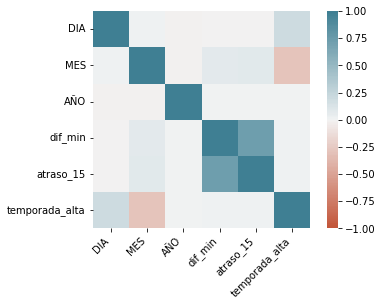

In [21]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

 OBS: No se presentan correlaciones de Pearson determinantes más que la obvia entre los campos 'df_min' y el 'atraso_15' (variable objetivo) ya que una está en relación (funcional) con la otra.

#### 4.2 ¿Qué variables se esperaría que más influyeran en predecir atrasos? <a id="window"></a>

 En forma individual no se observan asociaciones directas por tasas entre variables dependientes y la objetivo 'atraso_15'. Las tasas de atraso de cada grupo se van reduciendo sin mayores diferencias en similares proporciones de representatividad en cada tabla.
 Es necesario aplicar un modelo multidimensional que explique mejor la proporción de atrasos no por cada campo sino por concentración de casos balanceados en cada clase, modelo que será suficientemente entrenado con el correspondiente shape y parametría propuesta de cada librería.

### 5.0 Build the Model on the Balanced Data Set <a id="trans"></a>

#### 5.1 Entrenamiento de un modelo random Forest. <a id="window"></a>

 A continuación desarrollaré un modelo de machine learning en forma directa sin mayores atendimientos a la aplicación de variables que mejor se ajustan ya que según vimos en casos anteriores no se vislumbran mejores campos a considerar relacionados al campo objetivo 'atraso_15'.
 
 Un modelo de Random Forest es un metaestimador que ajusta una serie de clasificadores de árboles de decisión. La librería sklearn en la que se basa el siguiente entrenamiento necesita todos los campos dependientes en formato numérico

In [22]:
df['atraso_15'].value_counts()

0    55592
1    12614
Name: atraso_15, dtype: int64

 Se observa un buen desbalance de casi 1/4 del total entre las clases de atraso y el resto

In [23]:
def dianom_num(texto):
    texto = str(texto)
    if texto == 'Lunes':
        n=1
    elif texto == 'Martes':
        n=2
    elif texto == 'Miercoles':
        n=3
    elif texto == 'Jueves':
        n=4
    elif texto == 'Viernes':
        n=5
    elif texto == 'Sabado':
        n=6
    else:
        n=7
    return n

In [24]:
df['DAY_OF_WEEK'] = df['DIANOM'].apply(lambda x: dianom_num(x))

In [25]:
df['DAY_OF_WEEK'].value_counts()

5    10292
4    10251
1    10131
7     9796
3     9722
2     9662
6     8352
Name: DAY_OF_WEEK, dtype: int64

In [26]:
from dateutil import parser

 A continuación se define un nuevo campo 'HORA', la cual toma la hora de operación de 'Fecha-O'

In [27]:
# Se parsea la string de Fecha-O para obtener el TIME de operación:
df['aux1'] = df['Fecha-O'].apply(lambda x: parser.parse(x))
df['aux2'] = df['aux1'].apply(lambda x: x.strftime('%H%M'))
df['HORA'] = df['aux2'].apply(lambda x: int(x))
df = df.drop(columns=['aux1','aux2'])

In [28]:
# Se redondea hacia abajo: (20")
import math

for index, row in df.iterrows():
    df.loc[index, 'HORA'] = math.floor(row['HORA'] / 100)

 Se definen los campos categóricos en variables (ficticias) binarias atendiendo al modelo de random forest (más abajo) que no admite campos no 
numéricos:

In [29]:
df = pd.get_dummies(df, columns=['Des-O','Emp-O','TIPOVUELO','OPERA','periodo_dia'])

 Como indicaba más arriba en el análisis exploratorio se quitan campos sin variación que no hacen al entrenamiento de un model de descenso del gradiente y también aquellos de "programación de vuelo" (*-I). Asimismo no puede participar campos funcionales como 'dif_min'. También debo quitar campos recodificados.

In [30]:
df_num = df.drop(columns=['Fecha-I',
 'Vlo-I',
 'Ori-I',
 'Des-I',
 'Emp-I',
 'Fecha-O',
 'Vlo-O',
 'Ori-O','DIANOM','SIGLAORI','SIGLADES','Fecha-I_',
 'Fecha-O_','dif_min'])
#,'temporada_alta'

In [31]:
#test_size=0.2: Se entrena con 80% datos y testeo 20% y random_state=13: semilla para que los resultados sean reproducibles
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df_num.drop(['atraso_15'], axis=1), df_num['atraso_15'], test_size=0.2, random_state=42)

In [32]:
# Rearmamos el dataframe original con la definición de grupos a modelar:
df_train = pd.concat([train_y, train_x],axis=1)
df_train['MODELING_GROUP'] = 'TRAINING'
df_test = pd.concat([test_y, test_x],axis=1)
df_test['MODELING_GROUP'] = 'TESTING'
df_train_test = pd.concat([df_train,df_test])

# Cuántos casos se distribuyeron:
df_train_test['MODELING_GROUP'].value_counts()

TRAINING    54564
TESTING     13642
Name: MODELING_GROUP, dtype: int64

In [33]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

RandomForestClassifier(random_state=13)

### 6.0 Evaluate model on the unbalanced training and testing data set (Random Forest) <a id="trans"></a>

 Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada que es computacionalmente costosa. Acá la métrica devuelta como .score es el accuracy promedio

In [34]:
predicted = model.predict(test_x)
model.score(test_x, test_y) #Análogo a accuracy_score(test_y, prediction)

0.8374138689341739

In [35]:
prediction = model.predict(test_x)

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
confusion_matrix(test_y, prediction)

array([[10637,   431],
       [ 1787,   787]])

In [36]:
f1_score(test_y,prediction)

0.4150843881856541

In [37]:
roc_auc_score(test_y,prediction)

0.6334043571575194

 La precisión (accuracy) se usa cuando los verdaderos positivos (787) y los verdaderos negativos (10637) son más importantes, mientras que la puntuación F1_score mejor aplica cuando los falsos negativos (431) y los falsos positivos (1787) son fundamentales. Sin embargo aquí no estamos considerando importancia externa que condicione a los falsos positivos y/o a los falsos negativos.
 En este caso donde la distribución de clases de 'atraso_15' NO es similar ya que es de casi 1/4, la puntuación F1 es una mejor métrica.
Por lo tanto si bien la buena precisión de 0.837... podría ser un buen entrenamiento para estimar, la F1_score de 0.415... no es buena.
 Tampoco resulta aceptable una evaluación de curva AUC (curva ROC) de 0.633...

 Independientemente de la buena accuracy o la mala F1_score o la mediocre curva ROC sigo el procesamiento para obtener una predicción de la estimación de atraso según 'Fecha_O', 'temporada_alta', 'Des_O', 'Emp_O', 'TIPOVUELO', 'OPERA' y 'periodo_dia' para definir predicciones pntuales en cada caso:

In [38]:
def predict_delay(Fecha_O, temporada_alta, Des_O, Emp_O, TIPOVUELO, OPERA, periodo_dia):

    try:
        departure_date_time_parsed = datetime.strptime(Fecha_O, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    year = departure_date_time_parsed.year
    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    Des_O = Des_O.upper()
    Emp_O = Emp_O.upper()
    TIPOVUELO = TIPOVUELO.upper()
    OPERA = OPERA.upper()

    input = [{'DIA': day,
              'MES': month,
              'AÑO': year,
              'temporada_alta': 1 if 'temporada_alta' == 1 else 0,
              'Des-O_CYYZ': 1 if Des_O == 'CYYZ' else 0,
              'Des-O_EGLL': 1 if Des_O == 'EGLL' else 0,
              'Des-O_EGYP': 1 if Des_O == 'EGYP' else 0,
              'Des-O_KATL': 1 if Des_O == 'KATL' else 0,
              'Des-O_KDFW': 1 if Des_O == 'KDFW' else 0,
              'Des-O_KIAD': 1 if Des_O == 'KIAD' else 0,
              'Des-O_KIAH': 1 if Des_O == 'KIAH' else 0,
              'Des-O_KJFK': 1 if Des_O == 'KJFK' else 0,
              'Des-O_KLAX': 1 if Des_O == 'KLAX' else 0,
              'Des-O_KMCO': 1 if Des_O == 'KMCO' else 0,
              'Des-O_KMIA': 1 if Des_O == 'KMIA' else 0,
              'Des-O_LEMD': 1 if Des_O == 'LEMD' else 0,
              'Des-O_LFPG': 1 if Des_O == 'LFPG' else 0,
              'Des-O_LIRF': 1 if Des_O == 'LIRF' else 0,
              'Des-O_MDPC': 1 if Des_O == 'MDPC' else 0,
              'Des-O_MMMX': 1 if Des_O == 'MMMX' else 0,
              'Des-O_MMUN': 1 if Des_O == 'MMUN' else 0,
              'Des-O_MPTO': 1 if Des_O == 'MPTO' else 0,
              'Des-O_NZAA': 1 if Des_O == 'NZAA' else 0,
              'Des-O_SAAR': 1 if Des_O == 'SAAR' else 0,
              'Des-O_SABE': 1 if Des_O == 'SABE' else 0,
              'Des-O_SACO': 1 if Des_O == 'SACO' else 0,
              'Des-O_SAEZ': 1 if Des_O == 'SAEZ' else 0,
              'Des-O_SAME': 1 if Des_O == 'SAME' else 0,
              'Des-O_SANT': 1 if Des_O == 'SANT' else 0,
              'Des-O_SANU': 1 if Des_O == 'SANU' else 0,
              'Des-O_SAWH': 1 if Des_O == 'SAWH' else 0,
              'Des-O_SAZN': 1 if Des_O == 'SAZN' else 0,
              'Des-O_SAZS': 1 if Des_O == 'SAZS' else 0,
              'Des-O_SBCT': 1 if Des_O == 'SBCT' else 0,
              'Des-O_SBFI': 1 if Des_O == 'SBFI' else 0,
              'Des-O_SBFL': 1 if Des_O == 'SBFL' else 0,
              'Des-O_SBGL': 1 if Des_O == 'SBGL' else 0,
              'Des-O_SBGR': 1 if Des_O == 'SBGR' else 0,
              'Des-O_SCAR': 1 if Des_O == 'SCAR' else 0,
              'Des-O_SCAT': 1 if Des_O == 'SCAT' else 0,
              'Des-O_SCBA': 1 if Des_O == 'SCBA' else 0,
              'Des-O_SCCF': 1 if Des_O == 'SCCF' else 0,
              'Des-O_SCCI': 1 if Des_O == 'SCCI' else 0,
              'Des-O_SCDA': 1 if Des_O == 'SCDA' else 0,
              'Des-O_SCFA': 1 if Des_O == 'SCFA' else 0,
              'Des-O_SCIE': 1 if Des_O == 'SCIE' else 0,
              'Des-O_SCIP': 1 if Des_O == 'SCIP' else 0,
              'Des-O_SCJO': 1 if Des_O == 'SCJO' else 0,
              'Des-O_SCNT': 1 if Des_O == 'SCNT' else 0,
              'Des-O_SCPQ': 1 if Des_O == 'SCPQ' else 0,
              'Des-O_SCQP': 1 if Des_O == 'SCQP' else 0,
              'Des-O_SCSE': 1 if Des_O == 'SCSE' else 0,
              'Des-O_SCTE': 1 if Des_O == 'SCTE' else 0,
              'Des-O_SCVD': 1 if Des_O == 'SCVD' else 0,
              'Des-O_SEGU': 1 if Des_O == 'SEGU' else 0,
              'Des-O_SEQM': 1 if Des_O == 'SEQM' else 0,
              'Des-O_SGAS': 1 if Des_O == 'SGAS' else 0,
              'Des-O_SKBO': 1 if Des_O == 'SKBO' else 0,
              'Des-O_SLCB': 1 if Des_O == 'SLCB' else 0,
              'Des-O_SLLP': 1 if Des_O == 'SLLP' else 0,
              'Des-O_SLVR': 1 if Des_O == 'SLVR' else 0,
              'Des-O_SPJC': 1 if Des_O == 'SPJC' else 0,
              'Des-O_SPSO': 1 if Des_O == 'SPSO' else 0,
              'Des-O_SULS': 1 if Des_O == 'SULS' else 0,
              'Des-O_SUMU': 1 if Des_O == 'SUMU' else 0,
              'Des-O_YMML': 1 if Des_O == 'YMML' else 0,
              'Des-O_YSSY': 1 if Des_O == 'YSSY' else 0,
              'Emp-O_48O': 1 if Des_O == '48O' else 0,
              'Emp-O_56R': 1 if Des_O == '56R' else 0,
              'Emp-O_AAL': 1 if Des_O == 'AAL' else 0,
              'Emp-O_ACA': 1 if Des_O == 'ACA' else 0,
              'Emp-O_AFR': 1 if Des_O == 'AFR' else 0,
              'Emp-O_AMX': 1 if Des_O == 'AMX' else 0,
              'Emp-O_ARG': 1 if Des_O == 'ARG' else 0,
              'Emp-O_AUT': 1 if Des_O == 'AUT' else 0,
              'Emp-O_AVA': 1 if Des_O == 'AVA' else 0,
              'Emp-O_AZA': 1 if Des_O == 'AZA' else 0,
              'Emp-O_BAW': 1 if Des_O == 'BAW' else 0,
              'Emp-O_CMP': 1 if Des_O == 'CMP' else 0,
              'Emp-O_DAL': 1 if Des_O == 'DAL' else 0,
              'Emp-O_DSM': 1 if Des_O == 'DSM' else 0,
              'Emp-O_GLO': 1 if Des_O == 'GLO' else 0,
              'Emp-O_IBE': 1 if Des_O == 'IBE' else 0,
              'Emp-O_JAT': 1 if Des_O == 'JAT' else 0,
              'Emp-O_JMR': 1 if Des_O == 'JMR' else 0,
              'Emp-O_KLM': 1 if Des_O == 'KLM' else 0,
              'Emp-O_LAN': 1 if Des_O == 'LAN' else 0,
              'Emp-O_LAP': 1 if Des_O == 'LAP' else 0,
              'Emp-O_LNE': 1 if Des_O == 'LNE' else 0,
              'Emp-O_LPE': 1 if Des_O == 'LPE' else 0,
              'Emp-O_LRC': 1 if Des_O == 'LRC' else 0,
              'Emp-O_LXP': 1 if Des_O == 'LXP' else 0,
              'Emp-O_ONE': 1 if Des_O == 'ONE' else 0,
              'Emp-O_PUE': 1 if Des_O == 'PUE' else 0,
              'Emp-O_QFA': 1 if Des_O == 'QFA' else 0,
              'Emp-O_SKU': 1 if Des_O == 'SKU' else 0,
              'Emp-O_TAM': 1 if Des_O == 'TAM' else 0,
              'Emp-O_TPU': 1 if Des_O == 'TPU' else 0,
              'Emp-O_UAL': 1 if Des_O == 'UAL' else 0,
              'TIPOVUELO_I': 1 if TIPOVUELO == 'I' else 0,
              'TIPOVUELO_N': 1 if TIPOVUELO == 'N' else 0,
              'OPERA_Aerolineas Argentinas': 1 if OPERA == 'Aerolineas Argentinas' else 0,
              'OPERA_Aeromexico': 1 if OPERA == 'Aeromexico' else 0,
              'OPERA_Air Canada': 1 if OPERA == 'Air Canada' else 0,
              'OPERA_Air France': 1 if OPERA == 'Air France' else 0,
              'OPERA_Alitalia': 1 if OPERA == 'Alitalia' else 0,
              'OPERA_American Airlines': 1 if OPERA == 'American Airlines' else 0,
              'OPERA_Austral': 1 if OPERA == 'Austral' else 0,
              'OPERA_Avianca': 1 if OPERA == 'Avianca' else 0,
              'OPERA_British Airways': 1 if OPERA == 'British Airways' else 0,
              'OPERA_Copa Air': 1 if OPERA == 'Copa Air' else 0,
              'OPERA_Delta Air': 1 if OPERA == 'Delta Air' else 0,
              'OPERA_Gol Trans': 1 if OPERA == 'Gol Trans' else 0,
              'OPERA_Grupo LATAM': 1 if OPERA == 'Grupo LATAM' else 0,
              'OPERA_Iberia': 1 if OPERA == 'Iberia' else 0,
              'OPERA_JetSmart SPA': 1 if OPERA == 'JetSmart SPA' else 0,
              'OPERA_K.L.M.': 1 if OPERA == 'K.L.M.' else 0,
              'OPERA_Lacsa': 1 if OPERA == 'Lacsa' else 0,
              'OPERA_Latin American Wings': 1 if OPERA == 'Latin American Wings' else 0,
              'OPERA_Oceanair Linhas Aereas': 1 if OPERA == 'Oceanair Linhas Aereas' else 0,
              'OPERA_Plus Ultra Lineas Aereas': 1 if OPERA == 'Plus Ultra Lineas Aereas' else 0,
              'OPERA_Qantas Airways': 1 if OPERA == 'Qantas Airways' else 0,
              'OPERA_Sky Airline': 1 if OPERA == 'Sky Airline' else 0,
              'OPERA_United Airlines': 1 if OPERA == 'United Airlines' else 0,
              'periodo_dia_mañana': 1 if periodo_dia == 'mañana' else 0,
              'periodo_dia_noche': 1 if periodo_dia == 'noche' else 0,              
              'periodo_dia_tarde': 1 if periodo_dia == 'tarde' else 0,
              'DAY_OF_WEEK': day_of_week,
              'HORA': hour 
             }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [39]:
#predict_delay(Fecha_O, temporada_alta, Des_O, Emp_O, TIPOVUELO, OPERA, periodo_dia):
predict_delay('12/10/2016 21:45:00', 1,'MMUN', 'ARG', 'I', 'Aerolineas Argentinas','mañana') 

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.68

In [65]:
#predict_delay(Fecha_O, temporada_alta, Des_O, Emp_O, TIPOVUELO, OPERA, periodo_dia)
predict_delay('8/11/2017 08:35:00', 0,'EGYP', 'LAN', 'I', 'Grupo LATAM','mañana')

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.



0.67

In [66]:
#predict_delay(Fecha_O, temporada_alta, Des_O, Emp_O, TIPOVUELO, OPERA, periodo_dia)
predict_delay('25/3/2017 22:35:00', 0,'MMMX', 'AMX', 'I', 'Aeromexico','noche')

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.



0.74

 Las estimaciones de aquí arriba no poseen mayor caracter técnico que las sustente debido a la falta de balance del entrenamiento de las clases y la gran cantidad de campos incorporados que pueden perturbar la predicción como se observa en valores similares cuando los casos fueron SIN ATRASOS para los últimos dos casos de arriba (Fecha_O, temporada_alta, Des_O, Emp_O, TIPOVUELO, OPERA, periodo_dia) = ('25/3/2017 22:35:00', 0,'MMMX', 'AMX', 'I', 'Aeromexico','noche') y = ('8/11/2017 08:35:00', 0,'EGYP', 'LAN', 'I', 'Grupo LATAM','mañana').
 
 la intención de esta sección fue la de dar estimación puntual de pronóstico de un modelo de machine learning. Los procesamientos de balanceos y técnicas de influencia del modelo de pronóstico se ven a continuación.

### 6.0 Build the Model on the balanced Data Set (XGBoost) <a id="trans"></a>

 En esta sección se define otro modelo de descenso del gradiente (XGBoost) buscando una mejor evaluación de la función de score (F1_core)". El modelo XGBoost de clasificación es también un metaestimador que ajusta una serie de clasificadores de árboles de decisión pero de forma selectiva optimizada.
 
 A continuación previamente utilizo una librería (imbelearn) para balancear las clases de entrenamiento

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [43]:
smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 2, 3])

In [44]:
# Se sigue aplicando misma separación testing y training anterior:
x_res, y_res = smx.fit_sample(train_x, train_y.values.ravel())

In [45]:
df_x=pd.DataFrame(x_res)
df_x.columns = train_x.columns
df_y=pd.DataFrame(y_res)
df_y.columns = ['atraso_15']

In [46]:
df_y.mean(axis = 0)

atraso_15    0.5
dtype: float64

 Arriba se observa balanceo de ambas clases de decisión.
 
 A continuación se vuelve a apendizar extendiendo la cantidad original de casos (N = 68206 = TRAINING: 54564 + TESTING: 13642) según se había definido antes a 89048 debido al balanceo:

In [47]:
df_balanced = pd.concat([df_y, df_x], axis=1)
df_balanced.shape

(89048, 130)

 A continuación defino el pipeline para el proceso de entrenamiento:

In [48]:
features = [x for x in df_balanced.columns if x not in ['atraso_15']]
dependent=pd.DataFrame(df_balanced['atraso_15']) # Lista de la variable dependiente
independent=df_balanced.drop(columns=['atraso_15']) #Dataframe de variables independientes

In [49]:
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization

from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, export_graphviz

#### 7.1 Evaluate the model using an AUC and accuacy metrics <a id="window"></a>

In [50]:
import matplotlib.pylab as plt
%matplotlib inline

def evaluate_model(alg, train, target, predictors, early_stopping_rounds=10):
    
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(train[predictors].values, target['atraso_15'].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=10, nfold=10, metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['atraso_15'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
    plt.figure(figsize=(10, 10))
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['atraso_15'].values, dtrain_predictions))
    print("F1_score : %.4g" % metrics.f1_score(target['atraso_15'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['atraso_15'], dtrain_predprob))

In [51]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics

xgb0 = XGBClassifier(objective= 'binary:logistic', use_label_encoder =False)

In [52]:
#!pip3 install imbalanced-learn -- upgrade
!pip install plotly --upgrade
!pip install chart-studio --upgrade

     |████████████████████████████████| 15.2 MB 25.5 MB/s eta 0:00:01
  Attempting uninstall: plotly
    Found existing installation: plotly 5.1.0
    Uninstalling plotly-5.1.0:
      Successfully uninstalled plotly-5.1.0
     |████████████████████████████████| 64 kB 6.2 MB/s  eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=d95961996f5bb0779e864afc3a51ad8f35ed7ae20fd7321505d84a168b046d4c
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/ce/18/7f/e9527e3e66db1456194ac7f61eb3211068c409edceecff2d31
Successfully built retrying


In [53]:
#import chart_studio.plotly as py
#import plotly.graph_objs as go
#import plotly as plotly
#from sklearn import metrics

from sklearn.preprocessing import LabelEncoder

#import types

def __iter__(self): return 0


Model Report
Accuracy : 0.7044
F1_score : 0.7102
AUC Score (Balanced): 0.779597


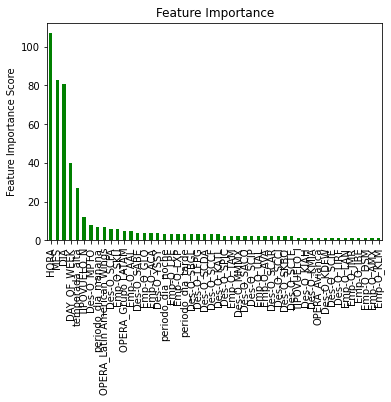

<Figure size 720x720 with 0 Axes>

In [54]:
# Puede alcanzar los 10' de ejecución:
evaluate_model(xgb0, independent, dependent,features)

 Para clasificar las predicciones y como el dataset está equilibrado se aplica la evaluación de curva ROC (AUC balanced) mejor que la f1_score. Acá si bien la precisión (o accuracy) es algo menor al modelo de clasificación anterior (Random Forest) se ha elevado el score AUC (balanced) por sobre ambos f1_score y accuracy
  
 En el gráfico de arriba se puede observar la relativa mejor importancia de los campos HORA, MES, DIA, DAY_OF_WEEK, temporada_alta, TIPOVUELO_N, periodo_dia_mañana, etc, en ese orden, para el entrenamiento de un modelo de XGBoost. Los 3 primeros campos se llevan la relativa importancia en más del 50% de eficacia del entrenamiento.
 
 A continuación evalúo el estimador entrenado tanto para el grupo de TESTING como para el resto de TRAINING con objeto de evaluar con el dataset original de 68206 casos (desbalanceado):

In [55]:
df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING'].copy()
df_training=df_train_test[df_train_test['MODELING_GROUP'] != 'TESTING'].copy()

#### 7.2 Evaluating with Confusion Matrix, Accuracy and AUC ROC Curve <a id="window"></a>

In [56]:
df_training['P_ATRASO']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_ATRASO'] = np.where(((df_training.P_ATRASO <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['atraso_15'].values, df_training['Y_ATRASO']))
print("F1_score : %.4g" % metrics.f1_score(df_training['atraso_15'].values, df_training['Y_ATRASO']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['atraso_15'], df_training['P_ATRASO']))

Accuracy : 0.6817
F1_score : 0.436
AUC Score (Train): 0.741041


In [57]:
df_testing['P_ATRASO']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing['Y_ATRASO'] = np.where(((df_testing.P_ATRASO <= .67)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['atraso_15'].values, df_testing['Y_ATRASO']))
print("F1_score : %.4g" % metrics.f1_score(df_testing['atraso_15'].values, df_testing['Y_ATRASO']))
print("AUC Score (Test): %f" % metrics.roc_auc_score(df_testing['atraso_15'], df_testing['P_ATRASO']))

Accuracy : 0.8236
F1_score : 0.2714
AUC Score (Test): 0.736921


In [58]:
print(pd.crosstab(df_training.Y_ATRASO, df_training.atraso_15))

atraso_15      0     1
Y_ATRASO              
0          30481  3327
1          14043  6713


In [59]:
print(pd.crosstab(df_testing.Y_ATRASO, df_testing.atraso_15))

atraso_15      0     1
Y_ATRASO              
0          10788  2126
1            280   448


 Las combinaciones de matrices de confusión junto a accuracy y al f1_score de ambos grupos de TRAINING y TESTING muestran evaluaciones "coherentes" respecto a las evaluaciones del entrenamiento con balanceo: La evaluación "AUC_score" en el entrenamiento balanceado es mucho más robusta que el "accuracy" y la "F1_score".
 
 Comparando ambos modelos de descenso del gradiente Random Forest y XGBoost podríamos aceptar una mejor performance del entrenamiento este último "XGBoost balanceado" cuando utilizamos el "AUC_score" ya que cualquiera de los 3 evaluaciones de este score tanto para el caso balanceado como para los casos de TRAINING (0.741...) y TESTING (0.736...) son mayores al AUC_score del caso Random Forest (de 0.633... calculado más arriba). Sin embargo debiera considerarse un Random Forest balanceado que no lo defino para no complicar este desafío.
 
 Aún quedan opciones de mejora sobre la influencia de los casos particulaes que hacen decrecer o aumentar la importancia de los campos y con ellos las pruebas de recambios de campos independientes en las definiciones de cualquier modelo de entrenamiento. Esto se analiza muy bien con una técnica llamada de Shap Values (https://shap.readthedocs.io/en/latest/index.html)

#### 7.3 Using shap_values to reconfigure <a id="window"></a>

 La técnica de Shap Values permite dimensionar la contribución positiva (o negativa) de cada campo utilizado en un entrenamiento hacia una mayor (menor) importancia en la dependencia de la campo/variable objetivo respecto a él. 
 
 La técnica emplea típicamente un gráfico mostrando cuánto afectó cada una de las característica a la predicción en relación a cuanto más alejado está del eje del promedio de las estimaciones puntuales dando una conclusión visual bien precisa cuando se comparan unos campos con otros.

In [60]:
!pip3 install shap

     |████████████████████████████████| 572 kB 22.4 MB/s eta 0:00:01


In [61]:
#!pip install plotly --upgrade
#!pip install chart-studio --upgrade

In [62]:
import shap
#from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [63]:
XX = independent
yy = dependent
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 0.2)

 NOTA: A los efectos de reducir los tiempos de ejecución de la técnica de shap value tomaré sólo los primeros 5000 casos del dataset. Si se desea obtener los gráficos con la data completa sólo comentar la celda de aquí abajo.
 Sin embargo tenga en cuenta que la ejecución de los shap_values puede tardar más de 3 horas (CPU con 4 cores)

In [101]:
XX_corta = XX[:3000]
yy_corta = yy[:3000]
XX_train, XX_test, yy_train, yy_test = train_test_split(XX_corta, yy_corta, test_size = 0.2)

 CUIDADO: La ejecución de la siguiente celda de los shap values para XGBoost puede tardar alrededor 3 horas (CPU con 4 cores) con el dataset completo:

In [64]:
# Prepares a default instance of the random forest regressor
modelMP = xgb0
#modelMP = xgb0
# Fits the model on the data
modelMP.fit(XX_train, yy_train)

# Fits the explainer
explainerMP = shap.Explainer(modelMP.predict, XX_test)
# Calculates the SHAP values - It takes some time
shap_valuesMP = explainerMP(XX_test)

[18:29:18] WARNING: /opt/conda/conda-bld/xgboost-ext_1658814095305/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Permutation explainer: 17811it [3:46:49,  1.31it/s]                             


 CUIDADO: La ejecución de la siguiente celda de los shap values para Random Forest puede tardar alrededor 3 horas (CPU con 4 cores) con el dataset completo:

In [84]:
# Prepares a default instance of the random forest regressor
modelMP_ = model
# Fits the model on the data
modelMP_.fit(XX_train, yy_train)

# Fits the explainer
explainerMP_ = shap.Explainer(modelMP_.predict, XX_test)
# Calculates the SHAP values - It takes some time
shap_valuesMP_ = explainerMP_(XX_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Permutation explainer: 1001it [03:26,  4.60it/s]                          


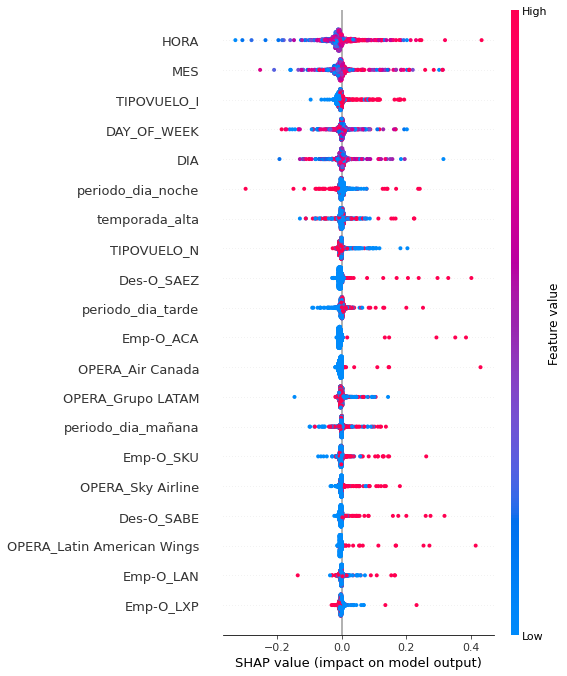

In [87]:
shap.summary_plot(shap_valuesMP_)

 En este gráfico de arriba se observa que los valores altos (color rojo) del campo 'HORA' tienen una contribución (impacto) positiva muy alta en la predicción y contribución negativa baja cuando sus valores son bajos (color azul). Similarmente se podría afirmar sobre los campos que le siguen de arriba hacia abajo 'MES' y 'tipovuelo_I'. Pero DAY_OF_WEEK y DIA son indistintos en su comportamiento de contribución. Similarmente aunque con poca influencia 'tipovuelo_N' se comporta alrevés que su otra clase internacional, ya que su bajo valor (azul) contribuye positivamente al entrenamiento, como debiera.
 
 Por lo tanto hacia alta horas de los arribos/partidas de los vuelos internacionales en SCL y hacia meses altos alcanzan para entrenar predicción de atrasos (con suficiente información histórica) con un modelo desbalanceado de Random Forest

In [251]:
# Prepares a default instance of the random forest regressor
modelMP_ = model
#modelMP = xgb0
# Fits the model on the data
#modelMP.fit(XX_train, yy_train)

# Fits the explainer
explainerMP_ = shap.Explainer(modelMP_.predict, XX_test)
# Calculates the SHAP values - It takes some time
shap_valuesMP_ = explainerMP_(XX_test)

Permutation explainer: 13643it [59:37,  3.80it/s]                            


 A continuación se tiene la ejecución de 3 celdas consecutivas de 3 primeros gráficos de shap values (shap_valuesMP_) para el modelo de Random Forest.
 
 Sin embargo me dentendré en explicar el caso XGBoost, que resulta mejor performante que el Random Forest, de sus gráficos de Shap Values (shap_valuesMP): 

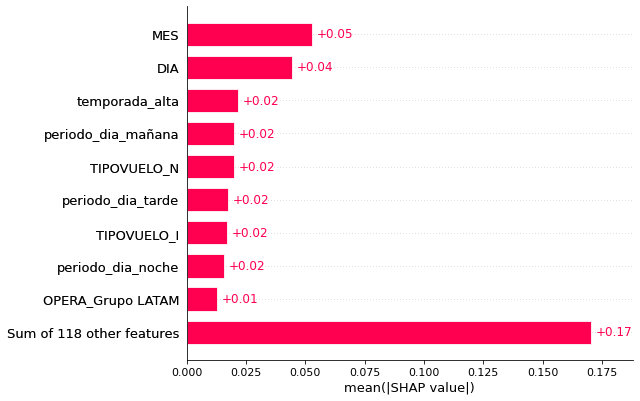

In [253]:
shap.plots.bar(shap_valuesMP_)

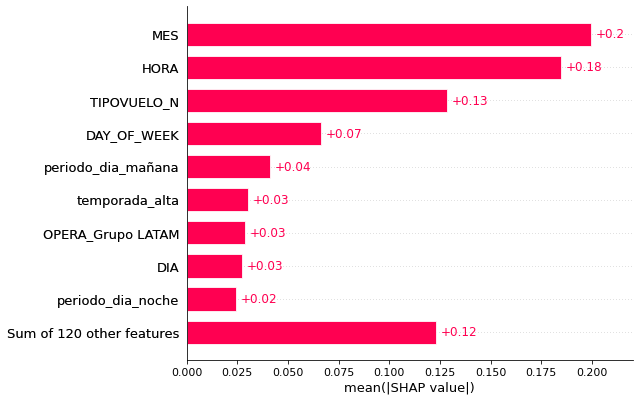

In [67]:
shap.plots.bar(shap_valuesMP)

 El gráfico de arriba de shap values correspondiente al modelo XGBoost (shap_valuesMP) balanceado entrenado antes muestra simplemente la mayor contribución que hace cada campo ordenado de arriba a abajo similar al grafico del Model Report del xbg0 de la librería xgboost.sklearn. Aquí las características se ordenan del mayor al menor efecto en la predicción teniendo en cuenta el valor SHAP absoluto. El modelo de XGBoost corrió con todos los casos.
 
 Se observa similar comportamiento a éste gráfico del modelo XGBoost, el gráfico de más arriba de Ramdom Forest (shap_valuesMP_) no balanceado que sin embargo primerizan más importantes los a los campos 'MES', TIPOVUELO' y 'periodo_dia_mañana' en su promedio de shap values (en valores absolutos). Pero queda por analizar la falta de contribución del campo 'HORA' en modelo Random Forest que corrión con sólo los primeros 5000 casos.

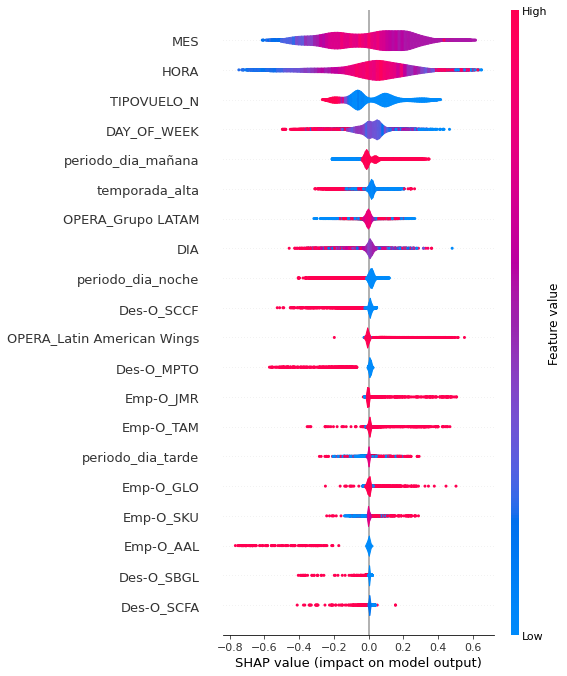

In [68]:
shap.summary_plot(shap_valuesMP, plot_type='violin')

  En este gráfico de arriba para XGBoost se observa que los valores altos (color rojo) del campo 'HORA' tienen una contribución (impacto) positiva muy alta en la predicción y contribución negativa baja cuando sus valores son bajos (color azul). Similarmente se podría afirmar sobre el campo 'periodo_dia_mañana'comportamiento similar al caso Randon Forest explicado arriba. Sin embargo el campo 'TIPOVUELO_N' contribuye negativamente con sus valores altos (High) indicando noche cuando se hubiera esperado un comportamiento contrario siguiendo al campo HORA. Sin embargo 'TIPOVUELO_N' es mucho menos relevante en la contribución al modelo que lo que aporta el campo 'HORA'.

### 8.0 Conclusiones: Cómo se podría mejorar la performance de los estimadores <a id="trans"></a>

 Recordando la falta de correlacion de Pearson entre 'DIA', 'MES', 'temporada_alta', etc, versus el campo 'atraso_15' ahora con las técnicas de entrenamiento (supervisado) se observan asociaciones entre estos campos y otros en conjunto con el campo/variable objetivo que se visualizan en puntos proyectados viviendo en hiperplanos que son suficientemente bien "alcanzados" (bajo descenso/aumento del gradiente) con el entrenamiento. Estos hiperplanos están parametrizados y son suceptibles de mejoras conforme se configura la parametría de cada librería al ir cargándoles más información.
 
 Las performances del par de estimadores propuestos así definidos sólo puede mejorada con mayor información. Sin embargo existen técnicas de ensayo y error que fácilmente pueden ser desarrolladas python donde se calculan el set de medidas de evaluación tradionales por cada ingreso y egreso de predictores en orden de rangos por Shap Values hasta alcanzar la mejor combinación para el set de datos de training/test específico. Esto tiene un costo de entrenamiento no menor pensando en los minutos que ha llevado el par de entrenamientos de arriba. Evidentemente es más sencillo ir quitando de a uno los campos menos representativos en los charts de shap values, que si bien se pierde en performance respecto a las combinaciones de ensayo/error se puede explicar mejor la variabilidad en la predicción de los atrasos por su sencillez.
 
 Las técnicas de ensayo/error deben alcanzar buenas performances cuando los períodos de entrenamiento se calculan por la determinación de las componentes estacionales y de eventuales componentes de tendencias de las series temporales implícitas de cada grupo OPERADOR dentro de una clusterización por bandas horarias y demás variables externas a la programación de los vuelos.
 
 